In [24]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

## Define parameters

In [25]:
user = "Marco"
learning_rate = 1e-3
input_size = 300
output_size = 100
batch_size = 10
num_epochs = 50
num_workers = 0
train_dir = os.path.join(os.getcwd(), 'data', 'train')
test_dir = os.path.join(os.getcwd(), 'data', 'test')
dtype_to_use = torch.float32

## Define the neural network architecture
Layer options (More info at https://pytorch.org/docs/stable/nn.html):
+ Linear: fully connected layer
+ Conv1d/Conv2d: Convolutional layers
+ BatchNorm2d/LayerNorm/InstanceNorm2d: Normalization layers
+ Dropout: Dropout layer
+ MaxPool2d/AvgPool2d: Pooling layers

In [26]:
class NN(pl.LightningModule):
    def __init__(self, learning_rate, input_size, output_size):
        super(NN, self).__init__()
        self.learning_rate = learning_rate
        self.layer1 = nn.Conv2d(1, 32, kernel_size=4, stride=1, padding="same", dtype=dtype_to_use)
        self.layer2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding="same", dtype=dtype_to_use)
        self.layer3 = nn.Conv2d(64, 128, kernel_size=4, stride=1, padding="same", dtype=dtype_to_use)
        self.layer4 = nn.Linear(128*11**2, 2000, dtype= dtype_to_use)
        self.layer5 = nn.Linear(2000, 500, dtype=dtype_to_use)
        self.layer6 = nn.Linear(500, output_size*2, dtype= dtype_to_use)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)

        self.relu = nn.ReLU()
        #self.loss_fn = nn.MSELoss()

        self.training_step_outputs = []
        self.testing_step_outputs = []

        self.save_path = None
    
    def forward(self, x):
        current_batch_size = x.shape[0]
        x = x.view(current_batch_size, 1, input_size, input_size)
        x = self.pool(self.relu(self.layer1(x)))
        x = self.pool(self.relu(self.layer2(x)))
        x = self.pool(self.relu(self.layer3(x)))
        x = x.view(current_batch_size, -1)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = x.view(current_batch_size, -1, output_size)
        return x
    
    def loss_fn(self, outputs, targets):
        abs_diff = torch.abs(outputs - targets)
        avg_distance = torch.mean(abs_diff)
        return avg_distance

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def on_train_epoch_end(self):
        if self.current_epoch == self.trainer.max_epochs - 1:
            # Calculate distances for the last epoch
            avg_distances, max_distances = self.calculate_distances(self.training_step_outputs, True)
            for i, avg_distance in enumerate(avg_distances):
                self.logger.experiment.add_scalar("train/avg_distance", avg_distance, i)
                self.logger.experiment.add_scalar("train/max_distance", max_distances[i], i)	

    def on_test_end(self):
        if self.current_epoch >= self.trainer.max_epochs - 1:
            # Calculate distances for the last epoch
            avg_distances, max_distances = self.calculate_distances(self.testing_step_outputs)
            for i, avg_distance in enumerate(avg_distances):
                self.logger.experiment.add_scalar("test/avg_distance", avg_distance, i)
                self.logger.experiment.add_scalar("test/max_distance", max_distances[i], i)

            

    def calculate_distances(self, output_target_pairs, train = False):
        if self.save_path is None:
            self.save_path = os.path.join(os.getcwd(), "logs", f"results_{user}", f"version_{self.logger.version}", "airfoils")
            if not os.path.exists(self.save_path):
                os.mkdir(self.save_path)
    
        avg_distances, max_distances = [], []
        for i, pair in enumerate(output_target_pairs):
            output, target = pair
            if train and i%100 == 0:
                pd.DataFrame(output.cpu().detach().numpy()).to_csv(os.path.join(self.save_path, f"output_{i}.csv"))
                pd.DataFrame(target.cpu()).to_csv(os.path.join(self.save_path, f"target_{i}.csv"))
            avg_distance, max_distance = self.calculate_distance(output, target)
            avg_distances.append(avg_distance)
            max_distances.append(max_distance)

        return avg_distances, max_distances

    def calculate_distance(self, output, target):
        abs_diff = torch.abs(output - target)
        avg_distance = torch.mean(abs_diff)
        max_distance = torch.max(abs_diff)
        return (avg_distance.item(), max_distance.item())
    

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        loss = self.loss_fn(outputs, targets)
        if torch.isnan(loss):
            self.trainer.should_stop = True
        self.log("train_loss", loss)
        if self.current_epoch == self.trainer.max_epochs - 1:
            for output, target in zip(outputs, targets):
                self.training_step_outputs.append((output, target))
        else:
            self.training_step_outputs = []
        return loss
    
    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        loss = self.loss_fn(outputs, targets)
        self.log("test_loss", loss)
        if self.current_epoch >= self.trainer.max_epochs - 1:
            for output, target in zip(outputs, targets):
                self.testing_step_outputs.append((output, target))
        else:
            self.testing_step_outputs = []
        return loss


## Custom dataset class

In [27]:
class CustomDataset(Dataset):
    def __init__(self, data, device):
        self.data = data
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Assuming each item in the dataset is a tuple of (input, output)
        sample = self.data[index]
        input_array, output_array = sample[0], sample[1]

        # Convert to PyTorch tensors
        input_tensor = torch.tensor(input_array, dtype=dtype_to_use, device=self.device)
        output_tensor = torch.tensor(output_array, dtype=dtype_to_use, device=self.device)

        return input_tensor, output_tensor
    
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, num_workers, device):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device
        self.train_ds = None
        self.test_ds = None

    def prepare_data(self):
        pass

    #Arrays are transposed to make size 100 instead of 2
    def setup(self, stage):
        train_data = []
        test_data = []
        for subdir in os.listdir(train_dir):
            input = cv2.imread(os.path.join(train_dir, subdir, 'polar_plot.png'), cv2.IMREAD_GRAYSCALE) 
            output = pd.read_csv(os.path.join(train_dir, subdir, 'coords.csv')).values.transpose()
            train_data.append((input, output))
        for subdir in os.listdir(test_dir):
            input = cv2.imread(os.path.join(train_dir, subdir, 'polar_plot.png'), cv2.IMREAD_GRAYSCALE) 
            output = pd.read_csv(os.path.join(test_dir, subdir, 'coords.csv')).values.transpose()
            test_data.append((input, output))

        self.train_ds = CustomDataset(train_data, self.device)
        self.test_ds = CustomDataset(test_data, self.device)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

In [28]:
# Set device cuda for GPU if it's available otherwise run on the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device == torch.device("cuda"):
    print(f"Using: {torch.cuda.get_device_name(device)}")
else:
    print("Using: CPU")
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
lightning_model = NN(learning_rate=learning_rate, input_size=input_size, output_size=output_size).to(device)


dm = CustomDataModule(batch_size, num_workers, device)

Using: Quadro P600


# Train and plot loss over epochs, as well as average and maximum difference for every sample in the last epoch

In [29]:
#! Change this to your name so that each one has their results in a separate folder
tb_logger = TensorBoardLogger("logs", name=f"results_{user}")
trainer = pl.Trainer(max_epochs=num_epochs, logger=tb_logger)  # Adjust parameters as needed

# Train the model
trainer.fit(lightning_model, dm)
%tensorboard --logdir logs/results_Marco

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Marco\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
UsageError: Line magic function `%tensorboard` not found.


In [30]:
trainer = pl.Trainer(max_epochs=15, logger=tb_logger)  # Adjust parameters as needed

# Train the model
trainer.fit(lightning_model, dm, ckpt_path=rf".\logs\results_{user}\version_19\checkpoints\epoch=13-step=1820.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at .\logs\results_Marco\version_19\checkpoints\epoch=13-step=1820.ckpt
c:\Users\Marco\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:337: UserWarning: The dirpath has changed from 'logs\\results_Marco\\version_19\\checkpoints' to 'logs\\results_Marco\\version_22\\checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type      | Params
-------------------------------------
0 | layer1 | Conv2d    | 544   
1 | layer2 | Conv2d    | 32.8 K
2 | layer3 | Conv2d    | 131 K 
3 | layer4 | Linear    | 31.0 M
4 | layer5 | Linear    | 1.0 M 
5 | layer6 | Li

Epoch 14: 100%|██████████| 130/130 [00:20<00:00,  6.24it/s, v_num=22]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 130/130 [00:39<00:00,  3.27it/s, v_num=22]


## View predicted and true airfoil coordinates

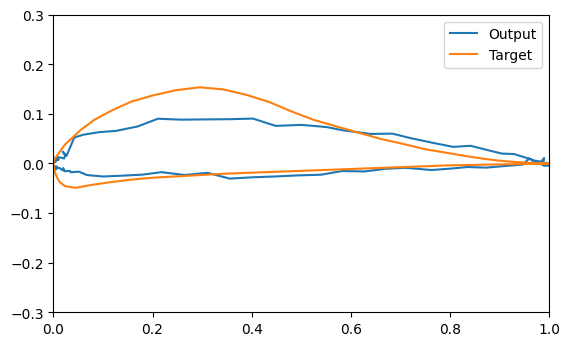

In [44]:
output_files = [file for file in os.listdir(lightning_model.save_path) if file.endswith('.csv') and file.startswith('output')]
# Loop through each CSV file
for file in output_files:
    # Extract the index from the file name
    index = int(file.split('_')[1].split('.')[0])
    
    # Read the CSV file
    df_output = pd.read_csv(os.path.join(lightning_model.save_path, file))
    df_target = pd.read_csv(os.path.join(lightning_model.save_path, f"target_{index}.csv"))
    #remove Unnamed column
    df_output = df_output.iloc[:,1:]
    df_target = df_target.iloc[:,1:]
    
    # Show the coordinates from output_i and target_i
    plt.plot(df_output.iloc[0], df_output.iloc[1], label='Output')
    plt.plot(df_target.iloc[0], df_target.iloc[1], label='Target')
    #make x axes from 0 to 1 and y axes from -0.5 to 0.5
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0,1)
    plt.ylim(-0.3,0.3)
    plt.legend()
    plt.show()



# Get results from testing:


In [ ]:
trainer.test(lightning_model, dm)
